# this is all on a single fiber still
here I test how well it work not to use the A/B idea

In [2]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np

from astropy.io import fits
from astropy.stats import biweight_location
from sklearn.decomposition import PCA
import pickle
from matplotlib import pyplot as plt
% matplotlib inline
from collections import OrderedDict

import spectrum

In [4]:
def load_skys(ff,which="sky_spectrum"):
    skys = OrderedDict()
    shotids = OrderedDict()
    N = len(ff)
    sff = []
    for i,f in enumerate(ff):
        if i % 100 == 0:
            print("loading {} out of {}.".format(i,N))
        shotid = f.split("/")[2]
        exp = f.split("/")[3]
        try:
            ww,rb = pickle.load( open(f,'rb'), encoding='iso-8859-1' )
            skys[(shotid,exp)] = rb[which]/rb["fiber_to_fiber"] 
            shotids[(shotid,exp)] = f
        except:
            print("Error loading {}.".format(f))
            pass
    print("starting wl = ", ww[0], "A")
    return ww, skys, sff

In [5]:
IFU = "022"
amps = ['LL']
dir_rebin="pca_test/rebin"


In [6]:
fn_shotlist_pca = "shotlist_pca.txt"

with open(fn_shotlist_pca, 'r') as f:
    s = f.read()
shotlist_PCA = s.split()


In [7]:
# load rebinned data

import glob
def load_skys_for_shotlist(IFU, shotlist, amps):
    # load all skys for given list of shots
    # this newer version makes sure that there is always date for all four amplifieres
    ff = OrderedDict()
    for amp in amps:
        ff[amp] = []
    exposures = ['exp01','exp02','exp03']
    for shot in shotlist:
        if shot.startswith("#"):
            continue
        for e in exposures:
            pattern = "{}/{}/{}/multi_???_{}_???_{}_rebin.pickle".format(dir_rebin, shot, e,IFU, "??")
            fff = np.sort(glob.glob(pattern))
            if len( fff ) == 4:
                ff['LL'] += [fff[0]]
                #ff['LU'] += [fff[1]]
                #ff['RL'] += [fff[2]]
                #ff['RU'] += [fff[3]]
            else:
                print("WARNING: for {} exp {}, not all four amps have data, dropping ....".format(shot, e))
    skys = OrderedDict()
    for amp in amps:
        ww,skys[(IFU,amp)],sff = load_skys(ff[amp],which="sky_spectrum")

    return ww,skys


ww, skys = load_skys_for_shotlist(IFU, shotlist_PCA, amps)

shotids = [k for k in skys[(IFU,"LL")] ]

loading 0 out of 425.


/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/mxhf/.pyenv/versions/anaconda3-4.3.1/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


loading 100 out of 425.
loading 200 out of 425.
loading 300 out of 425.
loading 400 out of 425.
starting wl =  3494.74 A


In [8]:
#skys = OrderedDict()
#ww,skys[("022","LL")],sff = load_skys(ff_022_LL,which="sky_spectrum")

In [9]:
fiber = 75
XA = np.array( [skys[("022","LL")][k][fiber] for k in skys[("022","LL")] ] ) # Take only signle fiber as they all contain the same sky anyways
# reconstruct the sky in fiber B, (here fiber 75 in 022,LL).
XB = np.array( [skys[("022","LL")][k][fiber] for k in skys[("022","LL")] ] )

In [45]:
# hack to homogenize lengths, the rebinning does make sure
# that the wavelength grid always stars at the same wavelength
# but not necessarey, end at the same ( ther may be a few pixel more or less)
N = np.min([XA.shape[1], XB.shape[1], ww.shape[0]])
ww = ww[:N]
XA = XA[:,:N]
XB = XB[:,:N]
# selct wavelength subrange
#wstart = 4626.668686
#wend  = 5400.
wstart = 3495.
#wend = 5493.

wend = 5454.7638826

#ww = 
ii = (ww >= wstart) * (ww <= wend)

wwcut = ww[ii]
_XAcut = XA[:,ii]
_XBcut = XB[:,ii]


349 of 401 survive cut.


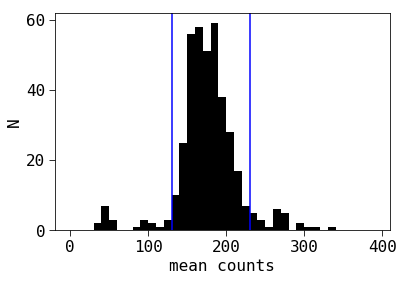

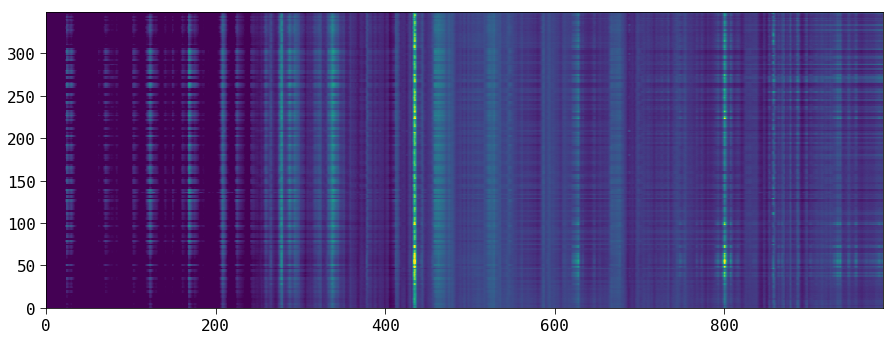

In [46]:
_mm = np.mean( _XAcut[:,450:600], axis=1)

start, stop = 130., 230.
jj = (_mm > start) * (_mm < stop)
print("{} of {} survive cut.".format(np.sum(jj),len(jj)))

if True:
    plt.hist(_mm,bins=np.arange(0,400,10))
    plt.axvline(start,c='b')
    plt.axvline(stop,c='b')
    plt.xlabel("mean counts")
    plt.ylabel("N")

    #% matplotlib notebook
    f = plt.figure(figsize=[15,15])
    #plt.imshow((XAcut.T/mm).T[jj*kk][:,275:300], vmin=.6,vmax=1.4, origin="bottom")
    plt.imshow((_XAcut.T/_mm).T[jj], vmin=.6,vmax=2.4, origin="bottom")

XAcut = (_XAcut[jj].T/_mm[jj]).T

mm = _mm[jj]

In [47]:

XBcut = XAcut

In [48]:
XAcut.shape

(349, 987)

In [49]:

# Add synthetic lines in every B - spectrum
# random wavelength
# random sigma (3.5 - 10. A)
# random amplitude (20 - 100. A)
if True:
    #generic gaussian
    def gauss(mu, sigma, x):
        return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -(x-mu)**2./(2. * sigma**2.))

    gg = []
    
    for i in range(XBcut.shape[0]):
        mu = np.random.uniform()* (wwcut[-1] - wwcut[0]) + wwcut[0]
        sigma = np.random.uniform() * 10. + 3.5
        A = np.random.uniform() * 90. + 50.

        g = A*gauss(mu, sigma, wwcut)

        XBcut[i]  = XBcut[i] + g/mm[i]
        
        gg.append(g)

In [50]:
MA = np.mean(XAcut,axis=0)
XAmean = XAcut - MA

In [51]:
MB = np.mean(XBcut,axis=0)
XBmean = XBcut - MB

[33.57873468 15.03666217  9.01842217  4.63391736  3.52753056  3.11427281
  2.17145731  1.86945835  1.64944108  1.45345454  1.27520337  1.06190037
  0.9167845   0.8700669   0.79919511  0.58236381  0.53486963  0.4921853
  0.47530386  0.44692975]


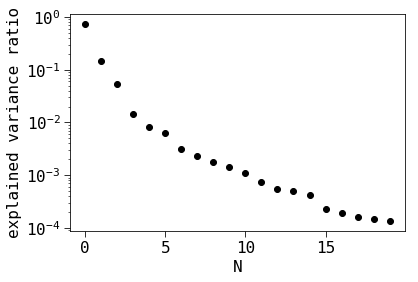

In [73]:
n_components = 20
pcaA = PCA(n_components=n_components)
pcaA.fit(XAmean)
plt.plot(pcaA.explained_variance_ratio_, 'o')  
plt.xlabel("N")
plt.ylabel("explained variance ratio")
plt.yscale('log')
print(pcaA.singular_values_) 

In [74]:
# project pca componets onto
# mean shifted input spectra
ccA = np.inner(XAmean,pcaA.components_)

# reconstruct pca comonents through linear combination
rcA = np.matmul( XAmean.T, ccA).T
# they wont be normalized yet
for i,cA in enumerate(rcA):
    rcA[i] = rcA[i]/np.linalg.norm(rcA[i])

#rc = rc/np.linalg.norm(rc,axis=1)

In [75]:
# make sure the result is the same
(np.abs( rcA - pcaA.components_) < 1e-6).all()

False

In [76]:
# compute projection of input spectra onto PCA basis
tA = pcaA.transform(XAmean)

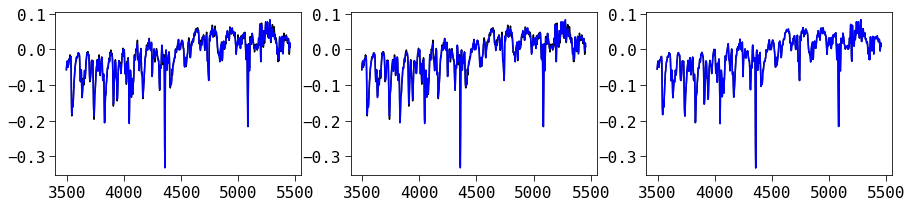

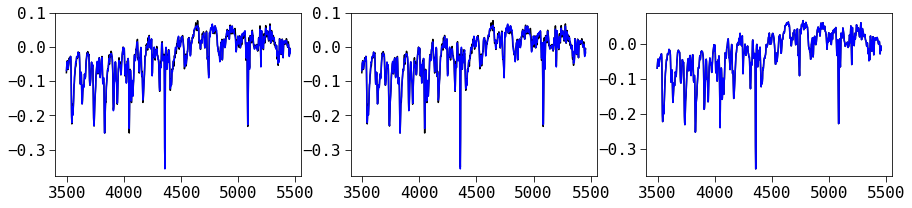

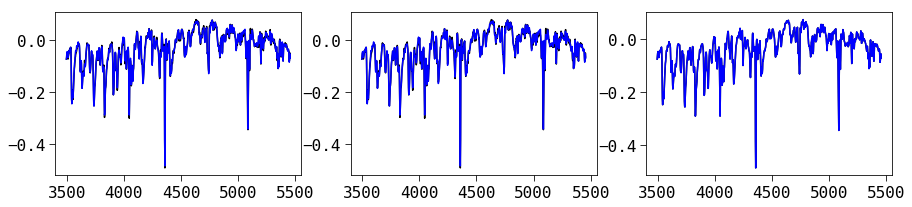

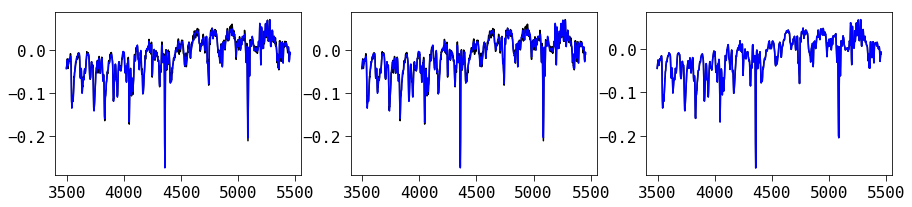

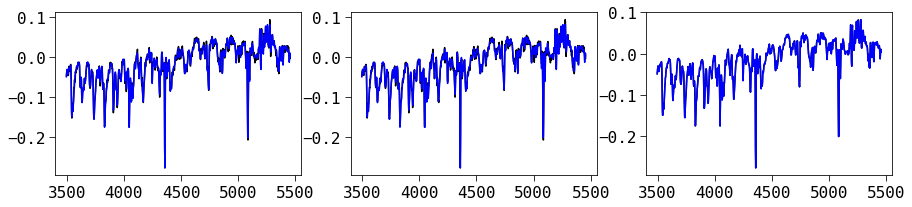

In [77]:
# make sure we can reconstruct the spectra from the
# actual principal components but also from the reconstructed ones
for i in range(5):
    f = plt.figure(figsize=[15,3])
    # plotting input mean spectra and
    # direct reconstruction from PCA
    plt.subplot(131)
    plt.plot( wwcut, XAmean[i] )
    # next two lines must have identical result
    plt.plot( wwcut, np.inner(tA, pcaA.components_.T)[i] )
    #plt.plot( wwcut, pcaA.inverse_transform(tA)[i] )


    plt.subplot(132)
    # plotting input mean spectra and
    #  reconstruction from rebuilt PCA components
    plt.plot( wwcut, XAmean[i] )
    plt.plot( wwcut, np.inner(tA, rcA.T)[i] )


    plt.subplot(133)
    # plot
    # direct reconstruction from PCA
    # and reconstruction from rebuilt PCA components
    # (but not input spectra)
    plt.plot( wwcut, np.inner(tA, pcaA.components_.T)[i] )
    plt.plot( wwcut, np.inner(tA, rcA.T)[i] )


In [78]:
# reconstruct pca components of B through linear combination of spectra from B
# BUT using projection from A
rcB = np.matmul( XBmean.T, ccA).T
# they wont be normalized yet
for i,cB in enumerate(rcB):
    rcB[i] = rcB[i]/np.linalg.norm(rcB[i])

In [79]:
# plot PCA components for A and B
if False:
    for i in range(pcaA.n_components):
        f = plt.figure(figsize=[15,2])
        plt.subplot(121)
        plt.plot( wwcut, pcaA.components_[i] )
        plt.subplot(122)
        plt.plot( wwcut, rcB[i] )    

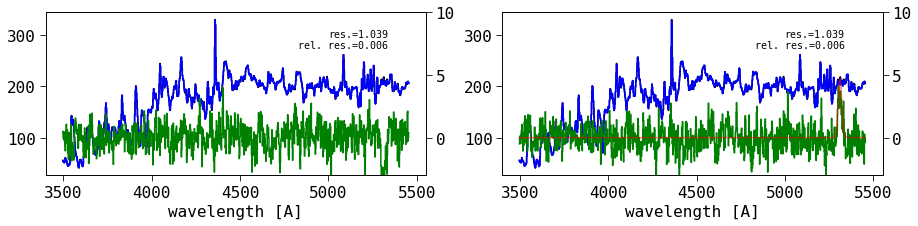

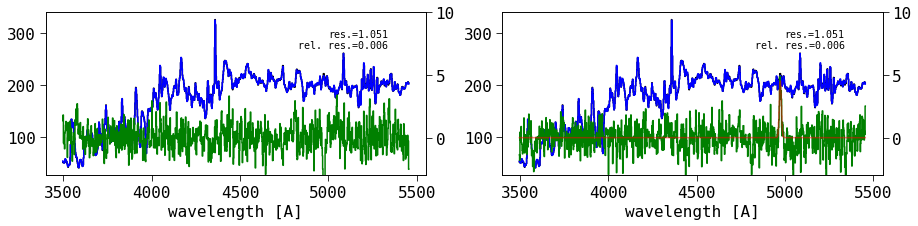

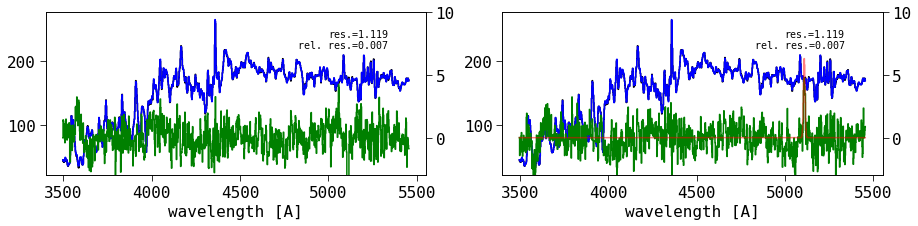

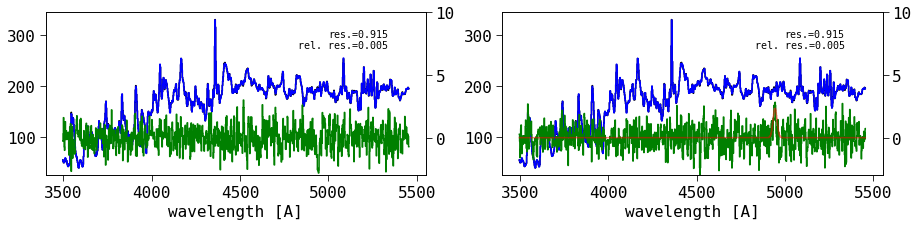

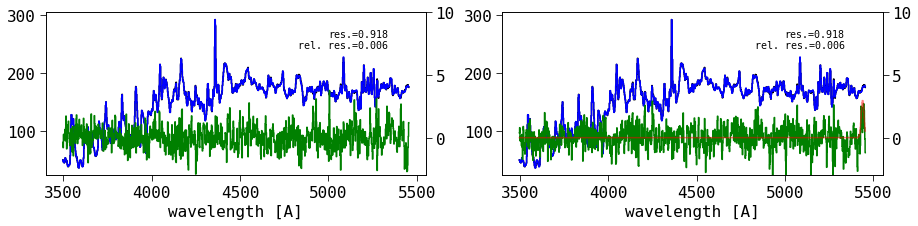

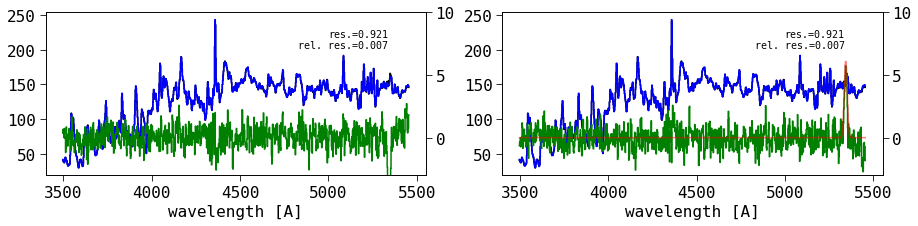

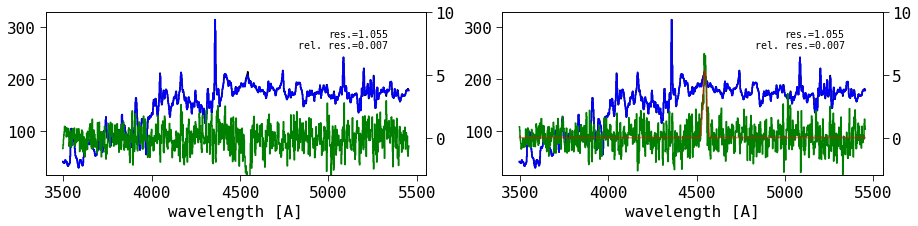

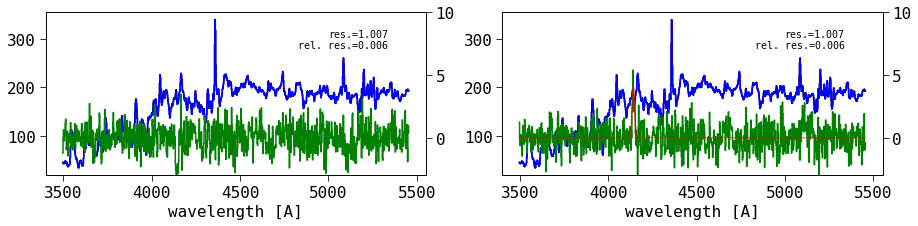

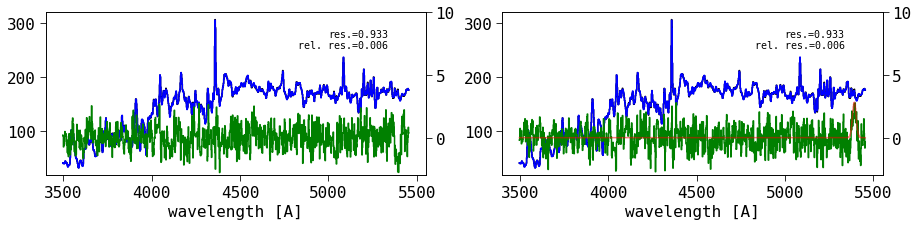

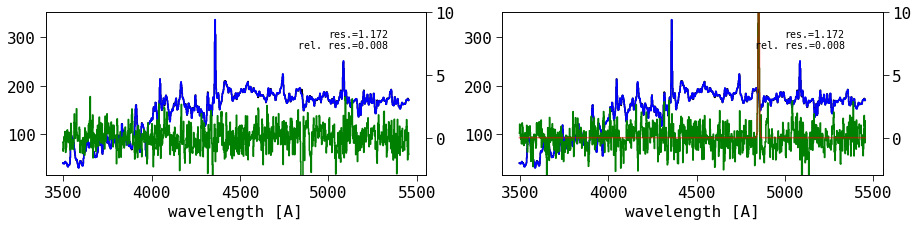

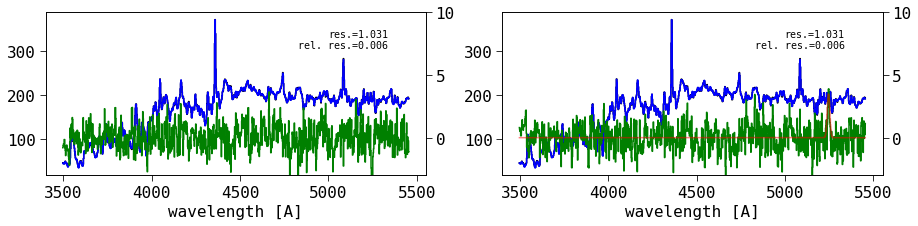

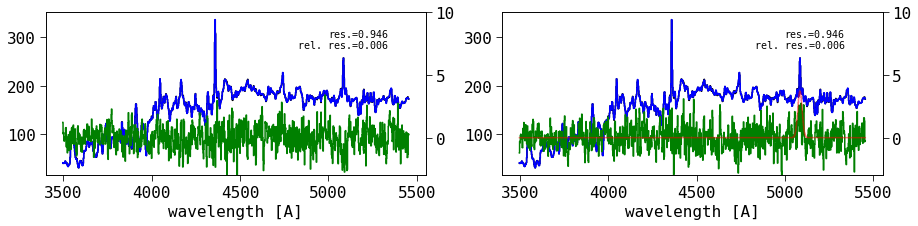

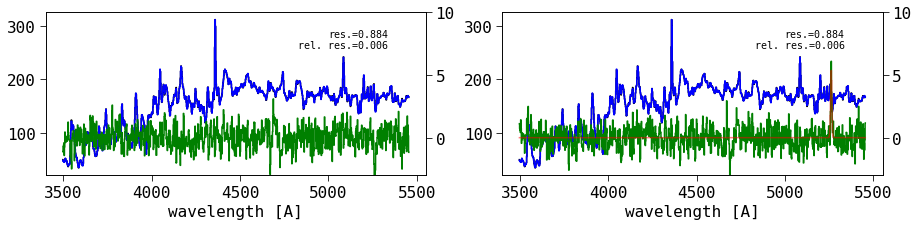

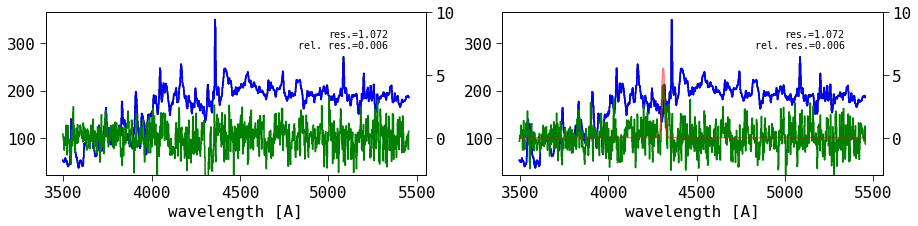

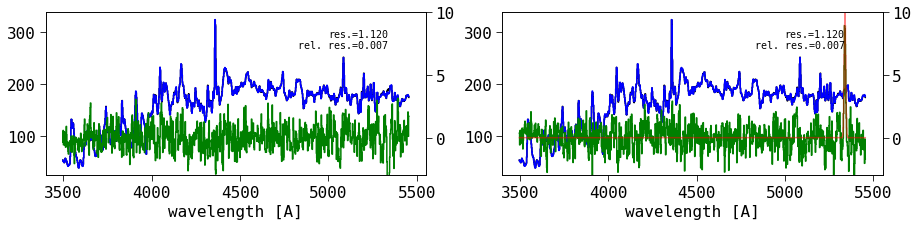

In [85]:
# Finally, check how well we are doing:
# Make sure we can reconstuct the spectra from the
# actual principal components for A but also from the reconstructed ones for B
for i in range(15):
    f = plt.figure(figsize=[15,3])
    ax = plt.subplot(121)
    
    y  = (XAmean[i] + MA) * mm[i]
    ry = (np.inner(tA, pcaA.components_.T)[i] + MA)  * mm[i]
    res = ry-y
    plt.plot(wwcut,  y , drawstyle='steps-mid' )
    plt.plot(wwcut, ry , drawstyle='steps-mid' )
    plt.xlabel("wavelength [A]")
    plt.twinx()
    plt.plot(wwcut,   res, 'g-' , drawstyle='steps-mid' )
    plt.ylim([-3,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
    
    

    ax = plt.subplot(122, sharex=ax)
    
    y  = (XBmean[i] + MB) * mm[i]
    #ry = (np.inner(tA, rcB.T)[i] + MB) * mm[i]
    ry = (np.inner(tA, pcaA.components_.T)[i] + MA)  * mm[i]
    res = y-ry
    
    plt.plot(wwcut,   y , drawstyle='steps-mid' )
    plt.plot(wwcut,   ry , drawstyle='steps-mid' )
    plt.xlabel("wavelength [A]")
    plt.twinx()
    
    plt.plot(wwcut,   res, 'g-' , drawstyle='steps-mid')
    plt.ylim([-3,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')


    plt.plot(wwcut,   gg[i], 'r-' , drawstyle='steps-mid', alpha=.5)


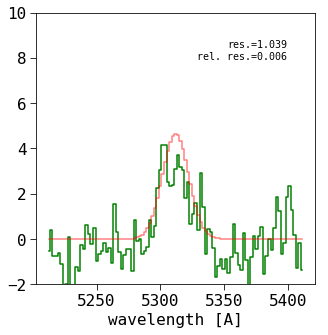

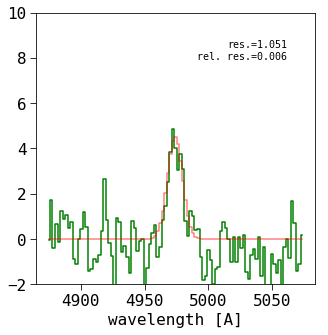

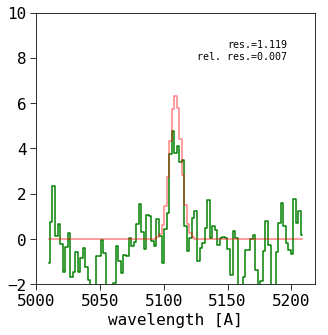

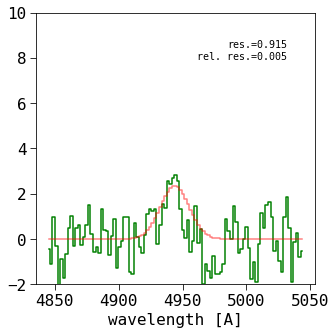

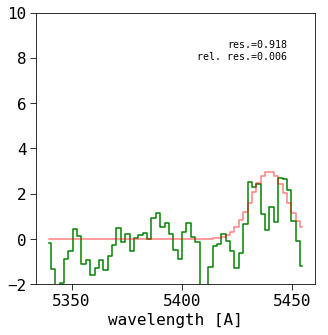

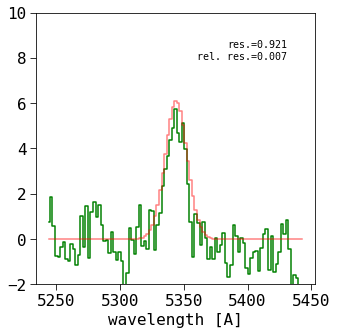

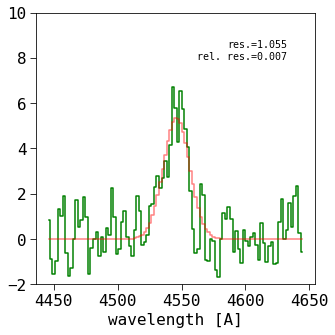

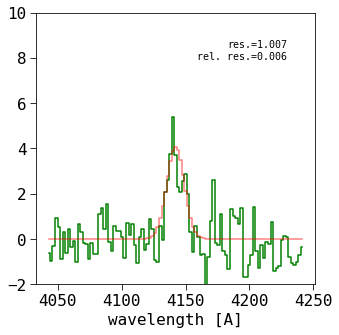

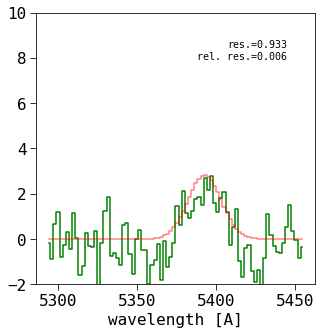

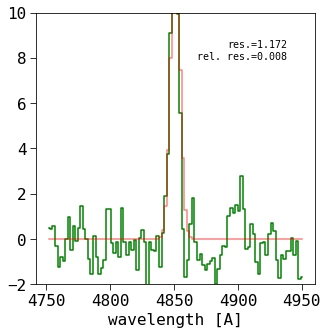

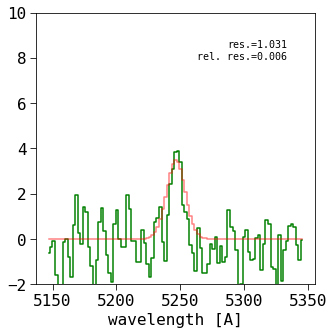

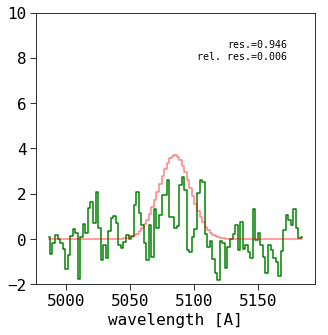

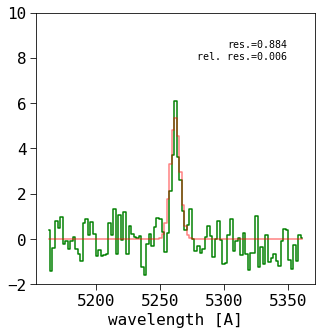

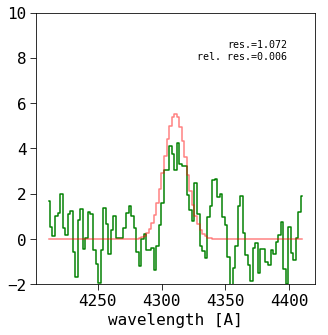

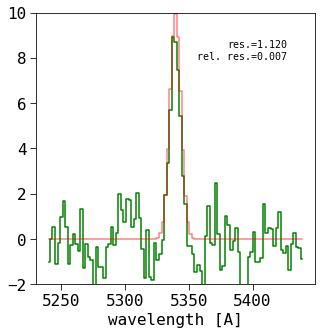

In [84]:
# Finally, check how well we are doing:
# Make sure we can reconstuct the spectra from the
# actual principal components for A but also from the reconstructed ones for B
for i in range(15):
    f = plt.figure(figsize=[5,5])
    ax = plt.subplot()
    y  = (XBmean[i] + MB) * mm[i]
    ry = (np.inner(tA, rcB.T)[i] + MB) * mm[i]
    res = y-ry

    wc = wwcut[np.argmax(gg[i])]
    ii = (wwcut > (wc-100.)) * (wwcut < (wc+100.))

    plt.plot(wwcut[ii],   res[ii], 'g-' , drawstyle='steps-mid')
    plt.ylim([-2,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')

    plt.plot(wwcut[ii],   gg[i][ii], 'r-' , drawstyle='steps-mid', alpha=.5)

    plt.xlabel("wavelength [A]")